In [3]:
from collections import Counter


In [1]:
import opennre
import nltk
from utilities import*
import json
from nltk.tokenize import sent_tokenize
nlp = spacy.load("en_core_web_sm")
from transformers import (WEIGHTS_NAME, AdamW, BertConfig,
                                  BertForTokenClassification, BertTokenizer,
                                  get_linear_schedule_with_warmup)
import spacy
from tqdm import tqdm
import networkx as nx
from nltk.corpus import stopwords


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
stopwords = set(stopwords.words('english')) 


In [3]:
model = opennre.get_model('wiki80_bertentity_softmax')

2021-05-24 08:32:32,472 - root - INFO - Loading BERT pre-trained checkpoint.


 root_path is /Users/ednovate/OpenNRE


In [4]:
full_text_directory = 'waves.txt'
text_directory = 'resolved_waves.txt'

In [5]:
text =open(text_directory)
text= text.read()
full_text = open(full_text_directory)
full_text = full_text.read()

In [6]:
resolved_json_dir ="cer_jsons/resolved_waves.json"

In [7]:
waves_cer = json.load(open(resolved_json_dir, 'r'))


In [8]:
punctuation = [":", "-", "'s", ".", "(", ")", ",", ";", "[", "]", "i.e."]

In [9]:
#make cer_list
cer_list = []
for span in waves_cer:
    for token in span: 
        if token['token'] != ['O'] and token['token'] not in cer_list and token['token'] not in stopwords and token['token'] not in punctuation:
            cer_list.append(token['token'])


In [10]:
top_k_words, top_k_indexer = topk(text, 40)

In [11]:
topk_no_stops = []
for word in top_k_words:
    if word not in stopwords:
        topk_no_stops.append(word)

In [13]:
topk_no_stops

['wave',
 'waves',
 'electromagnetic',
 'radiation',
 'energy',
 'wavelength',
 'information',
 'light',
 'grade',
 'based',
 'matter',
 'technologies',
 'cells',
 'frequency',
 'one',
 'another',
 'digitized',
 'stored',
 'relative',
 'discussion',
 'level',
 'different',
 'model',
 'features',
 'longer',
 'photoelectric',
 'materials',
 'multiple',
 'understanding',
 'interactions',
 'signals',
 'disciplinary',
 'core',
 'ideas',
 'chemical',
 'processes',
 'solar',
 'devices',
 'likewise']

In [14]:
#sentence tokenize doc
waves_sent_tokenized = sent_tokenize(text)


In [15]:
len(waves_sent_tokenized)

13

In [30]:
def doc_iterator1(tokenized_document: str, model, test_entities: List['str'], cer_entities: List[str]):

    triplets = []
    probr_tuples = []
    unique = []
    
    hrt_indexer = Indexer()

    for j,sentence in enumerate(tokenized_document):
        for entity in test_entities:
            for i,cer_entity in enumerate(cer_entities):
                if entity and cer_entity in sentence:
                    
                    #print("type of entity " + str(type(entity)))
                    #print(entity)
                    loader = nre_loader(entity,cer_entity, sentence)
                    probr_tuple = model.infer(loader)
                    #print("inference done")
                    relation  = probr_tuple[0]
                    prob = probr_tuple[1]
                    prob = round(prob,3)
                    #probr_tuples.append(probr_tuple)
                    h_r_t = (entity,relation,cer_entity)
                    
                    if hrt_indexer.contains(h_r_t) == False:
                        quadruplet = (entity,relation,cer_entity,prob)
                        unique.append(quadruplet)
                        
                    hrt_indexer.add_and_get_index(h_r_t)
                    
        print("end sentence " + str(j))
    return triplets, probr_tuples,unique

    


In [31]:
%%time

triplets, probr_tuples, unique = doc_iterator1(waves_sent_tokenized,model,topk_no_stops,cer_list )

end sentence 0
end sentence 1
end sentence 2
end sentence 3
end sentence 4
end sentence 5
end sentence 6
end sentence 7
end sentence 8
end sentence 9
end sentence 10
end sentence 11
end sentence 12
CPU times: user 1h 16s, sys: 6min 4s, total: 1h 6min 20s
Wall time: 17min


In [32]:
len(unique)

8331

In [33]:
unique[0:300]

[('wave', 'subsidiary', 'Disciplinary', 0.344),
 ('wave', 'subsidiary', 'Core', 0.343),
 ('wave', 'instance of', 'Ideas', 0.429),
 ('wave', 'follows', 'PS3.D', 0.286),
 ('wave', 'main subject', 'Energy', 0.395),
 ('wave', 'part of', 'Chemical', 0.576),
 ('wave', 'instance of', 'Processes', 0.437),
 ('wave', 'follows', 'Solar', 0.22),
 ('wave', 'instance of', 'cells', 0.645),
 ('wave', 'part of', 'human', 0.461),
 ('wave', 'part of', 'made', 0.188),
 ('wave', 'instance of', 'devices', 0.986),
 ('wave', 'follows', 'likewise', 0.302),
 ('wave', 'follows', 'capture', 0.252),
 ('wave', 'part of', 'sun', 0.531),
 ('wave', 'part of', '’s', 0.275),
 ('wave', 'part of', 'energy', 0.221),
 ('wave', 'followed by', 'produce', 0.324),
 ('wave', 'part of', 'electrical', 0.408),
 ('wave', 'follows', '3', 0.311),
 ('wave', 'instance of', 'electric', 0.279),
 ('waves', 'subsidiary', 'Disciplinary', 0.344),
 ('waves', 'instance of', 'Core', 0.573),
 ('waves', 'instance of', 'Ideas', 0.596),
 ('waves', '

In [34]:
## Check to see how many different relations are being used


relation_counter = {}
rel_array = []
for quadruplet in unique:
    rel = quadruplet[1]
    rel_array.append(rel)
    
    

In [35]:
rel_counter = Counter(rel_array)

In [36]:
rel_counter


Counter({'subsidiary': 37,
         'instance of': 875,
         'follows': 1031,
         'main subject': 613,
         'part of': 1771,
         'followed by': 1809,
         'developer': 15,
         'said to be the same as': 1314,
         'has part': 843,
         'field of work': 22,
         'applies to jurisdiction': 1})

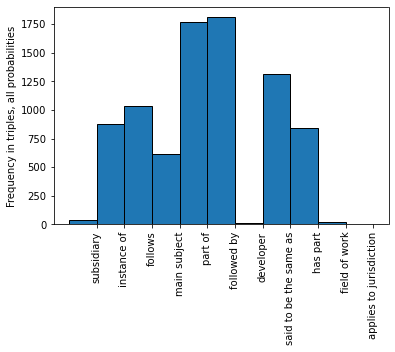

In [37]:
##graph occurrences of 
labels, values = zip(*rel_counter.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width,edgecolor="black", linewidth=1)
plt.ylabel('Frequency in triples, all probabilities')

plt.xticks(indexes + width * 0.5, labels)
plt.xticks(indexes + width * 0.5, labels, rotation = 'vertical')
plt.show()

In [38]:
def prob_filter(unique, prob_threhold):

	new_list = []
	for hrt in unique:
		if hrt[3] > prob_threhold:
			new_list.append(hrt)
	return new_list

In [39]:
subset = prob_filter(unique, 0.8)

In [40]:
len(subset)

318

In [41]:
subset

[('wave', 'instance of', 'devices', 0.986),
 ('waves', 'instance of', 'devices', 0.988),
 ('electromagnetic', 'instance of', 'devices', 0.99),
 ('radiation', 'instance of', 'devices', 0.988),
 ('energy', 'instance of', 'devices', 0.875),
 ('wavelength', 'instance of', 'devices', 0.986),
 ('information', 'instance of', 'devices', 0.988),
 ('light', 'instance of', 'devices', 0.988),
 ('grade', 'instance of', 'devices', 0.988),
 ('based', 'instance of', 'devices', 0.988),
 ('matter', 'instance of', 'devices', 0.986),
 ('technologies', 'instance of', 'devices', 0.986),
 ('cells', 'instance of', 'devices', 0.979),
 ('frequency', 'instance of', 'devices', 0.988),
 ('one', 'instance of', 'devices', 0.984),
 ('another', 'instance of', 'devices', 0.991),
 ('digitized', 'instance of', 'devices', 0.988),
 ('stored', 'instance of', 'devices', 0.986),
 ('relative', 'instance of', 'devices', 0.989),
 ('discussion', 'instance of', 'devices', 0.986),
 ('level', 'instance of', 'devices', 0.988),
 ('dif

In [42]:
for triplet in subset:
    print(str(triplet) + " \\\ " )

('wave', 'instance of', 'devices', 0.986) \\ 
('waves', 'instance of', 'devices', 0.988) \\ 
('electromagnetic', 'instance of', 'devices', 0.99) \\ 
('radiation', 'instance of', 'devices', 0.988) \\ 
('energy', 'instance of', 'devices', 0.875) \\ 
('wavelength', 'instance of', 'devices', 0.986) \\ 
('information', 'instance of', 'devices', 0.988) \\ 
('light', 'instance of', 'devices', 0.988) \\ 
('grade', 'instance of', 'devices', 0.988) \\ 
('based', 'instance of', 'devices', 0.988) \\ 
('matter', 'instance of', 'devices', 0.986) \\ 
('technologies', 'instance of', 'devices', 0.986) \\ 
('cells', 'instance of', 'devices', 0.979) \\ 
('frequency', 'instance of', 'devices', 0.988) \\ 
('one', 'instance of', 'devices', 0.984) \\ 
('another', 'instance of', 'devices', 0.991) \\ 
('digitized', 'instance of', 'devices', 0.988) \\ 
('stored', 'instance of', 'devices', 0.986) \\ 
('relative', 'instance of', 'devices', 0.989) \\ 
('discussion', 'instance of', 'devices', 0.986) \\ 
('level', '

In [38]:
## Check to see how many different relations are being used in the subset


subset_counter = {}
subset_array = []
for quadruplet in subset:
    rel = quadruplet[1]
    subset_array.append(rel)
    
    

In [39]:
subset_counter = Counter(subset_array)

In [40]:
subset_counter

Counter({'instance of': 141,
         'said to be the same as': 116,
         'followed by': 23,
         'part of': 12,
         'has part': 11,
         'main subject': 15})

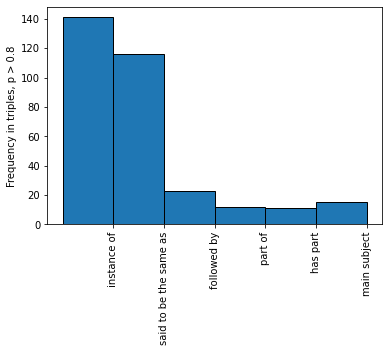

In [41]:
##graph occurrences of 
labels, values = zip(*subset_counter.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width, edgecolor= "black", linewidth=1)
plt.ylabel('Frequency in triples, p > 0.8')

plt.xticks(indexes + width * 0.5, labels)
plt.xticks(indexes + width * 0.5, labels, rotation = 'vertical')
plt.show()

In [42]:
probs = []
for hrt in unique:
    probs.append(hrt[3])

NameError: name 'Text' is not defined

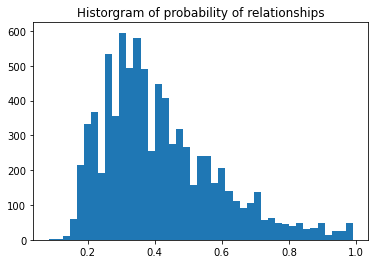

In [43]:
import matplotlib.pyplot as plt
rng = probs  # deterministic random data
a = rng
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Historgram of probability of relationships")
Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [62]:
def hrts_to_graph1(triplets): 
    """
    triplet: (e1,r,e2) triplets
    return: networkx Graph object, dict of labels for edges ( based on relation)

    """
    #print("working")
    G = nx.Graph()
    labels = {}
    #print("working")
    for triplet in triplets:
        e1 = triplet[0]
        r = triplet[1]
        e2 = triplet[2]
        #print("e1 " + str(e1) )
        #print("e2 " + str(e1) )

        G.add_edge(e1,e2)
        labels.update({(e1,e2):r})

    return G, labels

In [63]:
# trim probabilities off subset
subset_triples = []
for quadruplet in unique:
    e1 = quadruplet[0]
    relation = quadruplet[1]
    e2 = quadruplet[2]
    subset_triples.append((e1,relation,e2))

In [64]:
G, labels = hrts_to_graph1(subset_triples)

In [70]:
def word_graph(triplets, word:str):
	"""triplets: (e1, r, e2) triplets
	   return: networkx graph, labels
	"""
	word_triplets = []

	for triplet in triplets:
		if word in triplet:
			word_triplets.append(triplet)

	G, labels = hrts_to_graph(word_triplets)
	return G, labels

In [71]:
word_g, word_labels = word_graph(subset, 'wave')

e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 electromagnetic
e2 electromagnetic
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 waves
e2 waves
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave
e1 wave
e2 wave


In [76]:
def graph_kg1(G, labels: dict ):

	pos=nx.spring_layout(G)
	nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=600, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
	nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=10)

	
	plt.show()

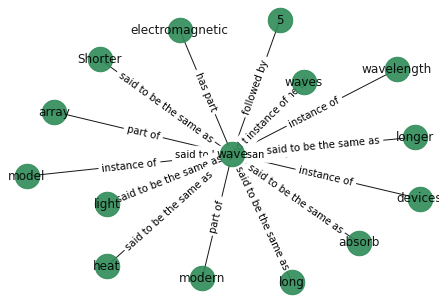

In [77]:
graph_kg1(word_g, word_labels)